### 0. Import libraries

In [76]:
# Torch and Torchlightning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import Pytorch modules
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# Sklearn for onehote encoding
from sklearn.preprocessing import LabelEncoder

# pandas
import pandas as pd

#Plotting tools 
import matplotlib.pyplot as plt

# some other utility modules
import random
import ast
import os

# Imports for SandiaPV
from pvlib import irradiance, temperature, pvsystem
from sandiapv_energy_prediction import *


## 1. Define model

In [77]:
class EnergyPredictionModel(nn.Module):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size):
        super(EnergyPredictionModel, self).__init__()
        self.dynamic_feature_size = dynamic_feature_size
        self.static_feature_size = static_feature_size
        self.hidden_size = hidden_size
        
        # LSTM module for dynamic features
        self.dynamic_rnn = nn.LSTM(input_size=dynamic_feature_size, hidden_size=hidden_size, batch_first=True)
        
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size + static_feature_size, hidden_size)  
        self.relu = nn.ReLU()  
        
        # Second Fully connected layer
        self.fc2 = nn.Linear(hidden_size, 3)
    
    def forward(self, dynamic_features, static_features):
        # Pass dynaamic features through LSTM
        _, (h_n, _) = self.dynamic_rnn(dynamic_features)
        h_n = h_n.squeeze(0)  
        
        # Concatenate dynamic features with static features
        concatenated_features = torch.cat((h_n, static_features), dim=1)
        
         # Pass concatenated features through first fully connected layer
        x = self.fc1(concatenated_features)
        x = self.relu(x)  
        
        # Pass through the second fully connected layer
        output = self.fc2(x)
        return output

## 2. Define training class


In [78]:
class TrainEnergyPrediction(pl.LightningModule):
    def __init__(self, dynamic_feature_size, static_feature_size, hidden_size, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
        self.loss_fn = nn.MSELoss()
        self.train_losses = []
        self.validation_losses = []
        self.test_losses = []

    def forward(self, x_dynamic, x_static):
        return self.model(x_dynamic, x_static)
    
    def training_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        loss = self.loss_fn(y_pred, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        val_loss = self.loss_fn(y_pred, y)
        self.log('val_loss', val_loss)
        self.validation_losses.append(val_loss.item())
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x_dynamic, x_static, y = batch
        y_pred = self(x_dynamic, x_static)
        test_loss = self.loss_fn(y_pred, y)
        self.log('test_loss', test_loss)
        self.test_losses.append(test_loss.item())
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)
        return optimizer


<style>
div.cell, div.input_area, div.output_area {
    background-color: #f0f0f0; /* Light grey color */
}
</style>

## 3. Load dataset

In [79]:
class SolarPanelDataset(Dataset):
    def __init__(self, csv_file):
        self.data_frame = pd.read_csv(csv_file, converters={
            'temperature_sequence': ast.literal_eval, 
            'wind_speed_sequence': ast.literal_eval, 
            'dni_sequence': ast.literal_eval, 
            'dhi_sequence': ast.literal_eval, 
            'global_irradiance_sequence': ast.literal_eval, 
            'gaussian': ast.literal_eval
        })
        
        # Label encoding for categorical variables
        self.encoder_panel = LabelEncoder()
        self.encoder_module = LabelEncoder()
        self.data_frame['panel_type'] = self.encoder_panel.fit_transform(self.data_frame['panel_type'])
        self.data_frame['module_type'] = self.encoder_module.fit_transform(self.data_frame['module_type'])

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Static features
        static_features = self.data_frame.iloc[idx][['panel_type', 'tilt', 'azimuth', 'module_type']].astype(np.float32).to_numpy()
        static_features = torch.tensor(static_features)
        
        # Dynamic features (entire daily weather data sequences)
        dynamic_features = np.column_stack([
            self.data_frame.iloc[idx]['temperature_sequence'],
            self.data_frame.iloc[idx]['wind_speed_sequence'],
            self.data_frame.iloc[idx]['dni_sequence'],
            self.data_frame.iloc[idx]['dhi_sequence'],
            self.data_frame.iloc[idx]['global_irradiance_sequence']
        ]).astype(np.float32)
        dynamic_features = torch.tensor(dynamic_features)

        # Gaussian parameters as output, stored as a list
        outputs = np.array(self.data_frame.iloc[idx]['gaussian']).astype(np.float32)
        outputs = torch.tensor(outputs)
        
        return dynamic_features, static_features, outputs

dataset = SolarPanelDataset('energy_data/model_input.csv')
data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

for i, data in enumerate(data_loader):
    if i > 10:
        break
    dynamic_inputs, static_inputs, outputs = data
    print("Static Inputs:", static_inputs) #Panel type, tilt, azimuth, module type
    print("Dynamic Inputs Shape:", dynamic_inputs.shape)   # Temperature, Wind, dni, dhi, global irradiance
    print("Outputs:", outputs) #Gaussian: Amplitude, Mean, standard deviation 

Static Inputs: tensor([[  0.,  31., 220.,   1.],
        [  0.,  29., 156.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.],
        [  0.,  31., 220.,   1.],
        [  0.,   7., 214.,   0.]])
Dynamic Inputs Shape: torch.Size([10, 24, 5])
Outputs: tensor([[17.2593, 11.4654,  1.4172],
        [80.1121,  9.8992,  1.9325],
        [85.2101, 11.8704,  3.5028],
        [90.1028, 13.2343,  2.5579],
        [ 6.7343, 10.3815,  1.9960],
        [99.3035, 11.1858,  3.6768],
        [25.8055, 11.4550,  2.1862],
        [72.7439, 10.0680,  1.9232],
        [76.9042,  9.8229,  1.5175],
        [28.0330, 11.3715,  1.8245]])
Static Inputs: tensor([[  0.,  29., 156.,   1.],
        [  0.,  29., 156.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,  31., 220.,   1.],
        [  0.,  29., 156.,   1.],
        [  0.,  29., 156.,   1.],

## 4. Train model

In [80]:
# Initialize the model
dynamic_feature_size = 5
static_feature_size = 4
hidden_size = 64
learning_rate = 1e-3
model = EnergyPredictionModel(dynamic_feature_size, static_feature_size, hidden_size)
 
# Initialize the Lightning module
train_module = TrainEnergyPrediction(dynamic_feature_size,static_feature_size,hidden_size,learning_rate)
train_module.model = model  

# Set up TensorBoard logger
log_dir = "tb_logs/my_model"
print("Log directory contents:", os.listdir(log_dir))
logger = TensorBoardLogger("tb_logs", name="my_model")

# Initialize the Lightning Trainer
trainer = pl.Trainer(max_epochs=10, logger =logger)
    
# Fit the model to the training data
trainer.fit(train_module, train_dataloaders=data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Log directory contents: ['version_0', 'version_1', 'version_10', 'version_11', 'version_2', 'version_3', 'version_4', 'version_5', 'version_6', 'version_7', 'version_8', 'version_9']


c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type                  | Params
--------------------------------------------------
0 | model   | EnergyPredictionModel | 22.8 K
1 | loss_fn | MSELoss               | 0     
--------------------------------------------------
22.8 K    Trainable params
0         Non-trainable params
22.8 K    Total params
0.091     Total estimated model params size (MB)
c:\Users\denni\anaconda3\envs\5ARIP\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## 5. Inspect performance

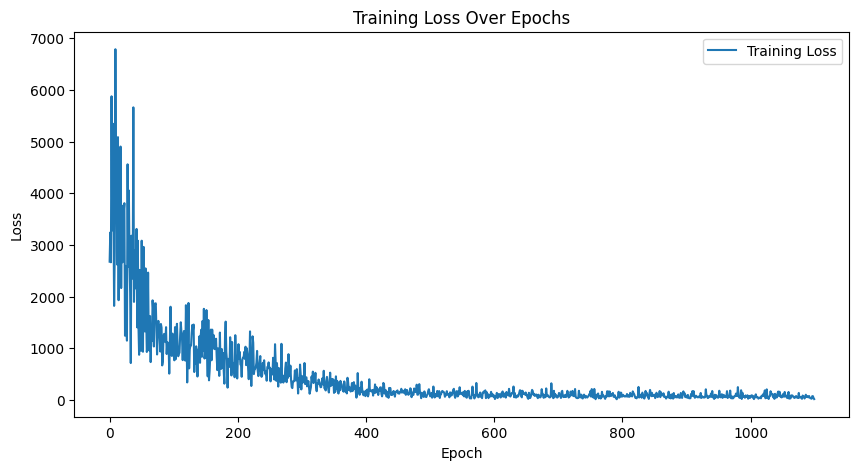

In [81]:
# After training
plt.figure(figsize=(10, 5))
plt.plot(train_module.train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

#### Launch tensorboard for advanced training insights

In [89]:
#Launch tensorboard for advanced training insights.

%reload_ext tensorboard
%tensorboard --logdir tb_logs/my_model

Reusing TensorBoard on port 6007 (pid 19988), started 21:18:57 ago. (Use '!kill 19988' to kill it.)

### Use model

tensor([[194.6490,  12.7491,   2.9446]]) torch.Size([1, 3])
[[194.64903    12.749095    2.9445672]] (1, 3)


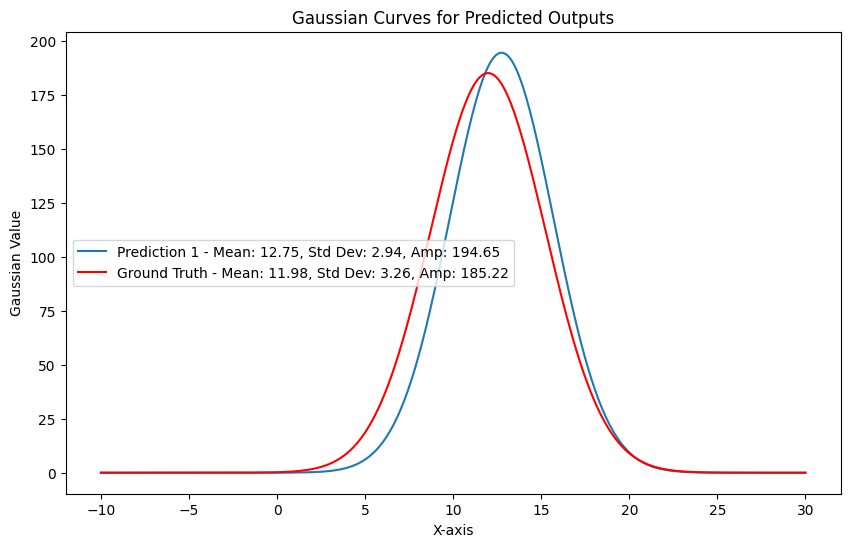

In [92]:
# Load the trained model
trained_model = train_module 
trained_model.eval() 

# Get a single sample from the data loader
sample_dynamic, sample_static, ground_truth = next(iter(data_loader))
sample =3
# Predict using a single example
with torch.no_grad():
    predictions = trained_model(sample_dynamic[sample].unsqueeze(0), sample_static[sample].unsqueeze(0))
print(predictions,predictions.shape)

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to plot Gaussian curves
def plot_gaussian(x, predictions,ground_truth, labels):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, label in enumerate(labels):
        a, b, c = predictions[i]
        y = gaussian(x, a, b, c)
        ax.plot(x, y, label=f'{label} - Mean: {b:.2f}, Std Dev: {c:.2f}, Amp: {a:.2f}')
    
     # Plot ground truth Gaussian curves
    gt_a, gt_b, gt_c = ground_truth[0]
    gt_y = gaussian(x, gt_a, gt_b, gt_c)
    ax.plot(x, gt_y, label=f'Ground Truth - Mean: {gt_b:.2f}, Std Dev: {gt_c:.2f}, Amp: {gt_a:.2f}', color='red')
    

    ax.set_title('Gaussian Curves for Predicted Outputs')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Gaussian Value')
    ax.legend()
    plt.show()

# Prepare x-axis for the plot
x_values = np.linspace(-10, 30, 400)

# Reshape predictions if necessary and convert to numpy if still in tensor form
predictions = predictions.squeeze().numpy().reshape(1, -1)
predictions = predictions
print(predictions, predictions.shape)
ground_truth = ground_truth[sample].squeeze().numpy().reshape(1, -1)
# Plot the Gaussian curve for the predicted values
plot_gaussian(x_values, predictions,ground_truth, labels=["Prediction 1"])